# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

*Add your implementation and discussion*

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

*Add your implementation and discussion*

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [20]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

[48824 11932 11570  6105  4442 17181  8684 49927 44794 38116]


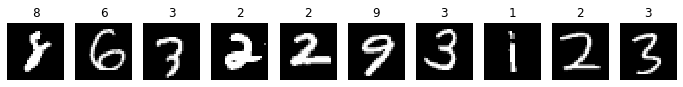

In [81]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP

We will use the PyTorch library to construct an MLP neural network. We choose an architecture with two hidden layers of 100 nodes each because it turned out to give better results than only one hidden layer.


In [22]:
import torch 
from torch import Tensor 
from torch import nn
from torch.nn import functional as F
from torch import optim

#### 1. Preprocessing
First, we convert the inputs and labels to Tensors and flatten the inputs from $28 \times 28$ to 784-dimensional representing the flatten 2D image.

In [54]:
#conditions 
n_input = 784
n_hidden = 100
n_output = 10
np.random.seed(0)

In [24]:
def preprocessing(data,labels): 
    return (torch.from_numpy(data).view(-1, n_input), torch.from_numpy(labels))

In [25]:
#conversion to tensors and flattening 
train_images_, train_labels_ = preprocessing(train_images,train_labels)
test_images_, test_labels_ = preprocessing(test_images,test_labels)

#### 2. Neural Network implementation
Using Pytorch implemented functions, we define our neural network with 3 linear layers. On the 2 first ones, we apply the chosen activation function Rectified Linear Units (ReLU). We choose this activation function because it is computationally lighter than others and because it prevents the apparition of the vanishing gradient problem. 

Pytorch library presents the advantageous autograd mechanism that consists in stocking the operations done on a variable (in the Tensor form) to automatically be able to calculate the backward pass when needed to optimize the parameters of the model. Hence the functional F.relu is an autograd complient function, similarly to the other operations we could perform in the following.

In [73]:
#define the net 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_output)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 3. Training the model

Now that the neural network is defined, it needs to be trained on our data set. We use an Adam optimizer, an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks, on a mini-batch approach. We previously compared it to using a stochastic gradient descent optimizer and the results on the last one were less promising.

Finally we plot the resuls for each epoch of the training to have an idea of the progression of the optimization. We used the cross entropy loss and the accuracy to get an idea of the performances.

In [94]:
def train_model(model, train_input, train_target, mini_batch_size, epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=0.01) 
    losses_tr = []
    accuracies_tr = []
    
    losses_te = []
    accuracies_te = []
    
    print("Start training Multi Layer Perceptron model...")
    
    model.train()
    
    for e in range(epochs):
        sum_loss=0.0
        correct=0.0

        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            optimizer.zero_grad()
            
            output = model(train_input.narrow(0, b, mini_batch_size))

            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))            
            loss.backward()
            
            optimizer.step() #equivalent of the for loop update 
          
        #results for training
        avg_loss_tr, avg_accuracy_tr = compute_performances(model, train_images_, train_labels_, mini_batch_size)
        if e % display_step ==0:            
            print('Epoch: %02d' %(e), ': train loss = ' + "{:.3f}".format(avg_loss_tr), ', train accuracy: ' + "{:.3f}".format(avg_accuracy_tr) + "%")
        losses_tr.append(avg_loss_tr)
        accuracies_tr.append(avg_accuracy_tr)
        
        #results for testing
        avg_loss_te, avg_accuracy_te = compute_performances(model, test_images_, test_labels_, mini_batch_size)
        if e % display_step ==0:            
            print('            test loss = ' + "{:.3f}".format(avg_loss_te), ', test accuracy: ' + "{:.3f}".format(avg_accuracy_te) + "%")
        losses_te.append(avg_loss_te)
        accuracies_te.append(avg_accuracy_te)
        
    # plot the accuracy and loss
    plt.figure(figsize = (20,10))
    plt.subplot(221)
    plt.plot(range(epochs), losses_tr, color='r')
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.title("Average Loss at training")
    plt.subplot(222)
    plt.plot(range(epochs), accuracies_tr)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.title("Accuracy at training (in %)")
    plt.subplot(223)
    plt.plot(range(epochs), losses_te, color='r')
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.title("Average Loss at testing")
    plt.subplot(224)
    plt.plot(range(epochs), accuracies_te)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.title("Accuracy at testing (in %)")
    plt.show()
            
    print("Training done...")
      

In [77]:
def compute_performances(model, inputs, labels, mini_batch_size):
    
    model.eval()
    
    sum_loss=0.0
    correct=0.0
    
    losses = []
    accuracies = []
    
    for b in range(0, inputs.size(0), mini_batch_size):
        #get the outputs from the trained model
        output = model(inputs.narrow(0, b, mini_batch_size)) #should have done it by mini batches 

        loss = criterion(output, labels.narrow(0, b, mini_batch_size))
        sum_loss += loss.item()
        
        predicted = torch.argmax(output, 1)
        correct += (predicted == labels.narrow(0, b, mini_batch_size)).sum().double()
    
    avg_loss=sum_loss/inputs.shape[0]
    avg_acc=100 * correct/inputs.shape[0]
    
    return avg_loss, avg_acc
    
    #print('Loss = {:.3f}'.format(avg_loss), "Accuracy: {:.3f}%".format(avg_acc))

Start training Multi Layer Perceptron model...
Epoch: 00 : train loss = 0.019 , train accuracy: 22.545%
            test loss = 0.019 , test accuracy: 22.450%
Epoch: 05 : train loss = 0.007 , train accuracy: 79.562%
            test loss = 0.007 , test accuracy: 79.770%
Epoch: 10 : train loss = 0.004 , train accuracy: 87.482%
            test loss = 0.004 , test accuracy: 87.130%
Epoch: 15 : train loss = 0.004 , train accuracy: 89.043%
            test loss = 0.004 , test accuracy: 88.370%
Epoch: 20 : train loss = 0.004 , train accuracy: 88.260%
            test loss = 0.005 , test accuracy: 87.550%


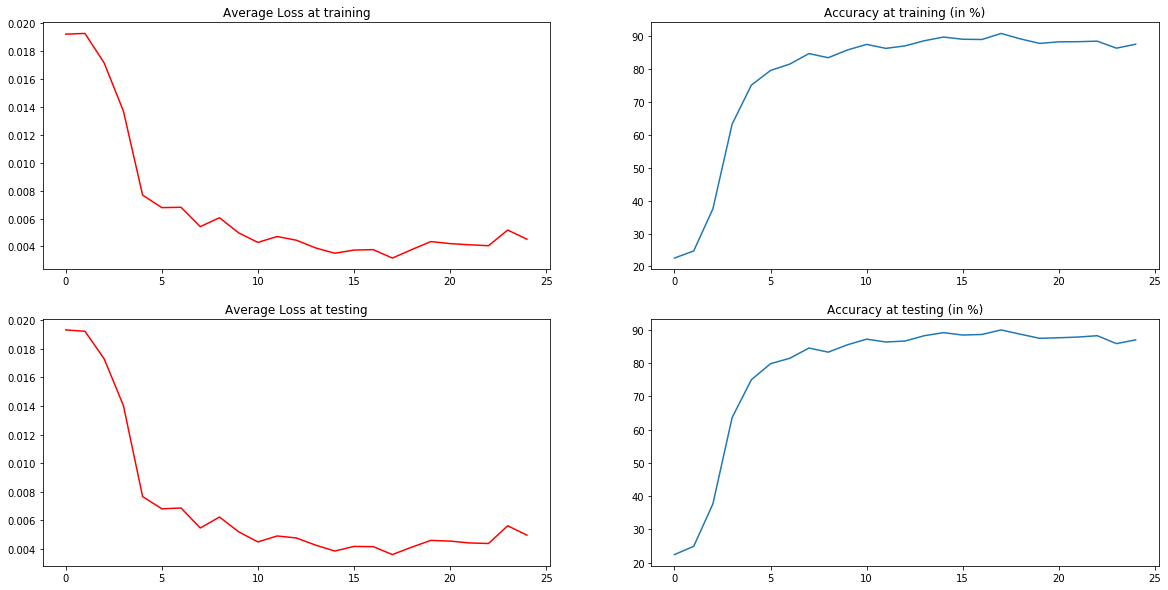

Training done...


In [93]:
model, criterion = Net(), nn.CrossEntropyLoss()
mini_batch_size = 100
epochs=25
display_step = 5

#train the parameters of the model on the dataset
train_model(model, train_images_, train_labels_, mini_batch_size, epochs)

#### Analysis and discussion
We can see pretty good performances, with a decreasing loss and an increasing accuracy during training, both reaching a plateau around the end. We also see that it doesn't seem to be overfitting, which makes sense regarding the low complexity of the network. 

#### Vizualization of the results
Finally, we vizualize the results on a random sample of the images. We see that the network was well-trained in recognizing the images as we only see one misclassified image. 

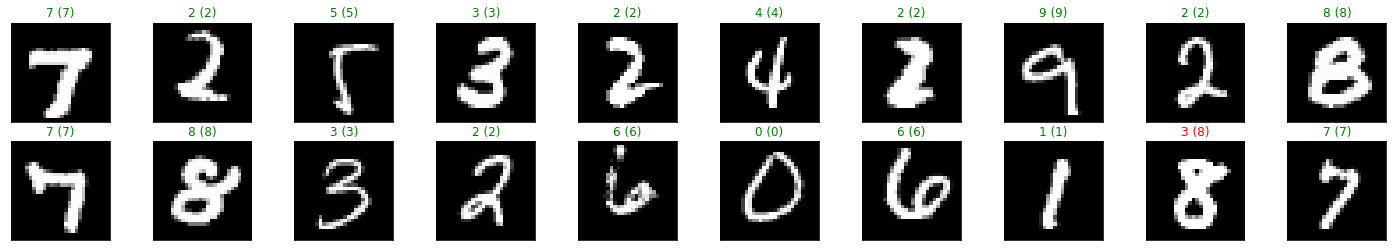

In [120]:
# obtain one batch of test images
nb_im=20
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=test_set_size, size=nb_im)

images=[]
labels=[]
for i in plt_ind:
    images.append(test_images[i])
    labels.append(test_labels[i])

images, labels = np.array(images),np.array(labels)
images_,labels_=preprocessing(images, labels)

# get sample outputs
output = model(images_.float())
# convert output probabilities to predicted class
preds = torch.argmax(output, 1)


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(nb_im):
    ax = fig.add_subplot(nb_im/10, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))